# RBC Dinamika
Hogyan konvergal a rendszer az allandosult allapotaba? Megoldasi modok:

- Egzakt megoldasok
  - Analitikusan: Ritkan a Bellman egyenlet value function-je meghatarozhato (method of undetermined coefficients), de ez csak nagyon specifikus esetekben mukodik.
  - Bellman egyenlet + value function iteration. Diszkretizaljuk a state space-t, majd grid searcheljuk a policy es value fuggvenyeket. Nagy dimenzionalitasu problemaknal kvazi lehetetlen, rosszul skalazodik.
  - Finite approximation: Feltetelezzuk, hogy kelloen nagy T valasztasa eseten a gazdasag T idoszak alatt konvergal az allandosult allapothoz es egy kozelito modszerrel meghatarozzuk az allapotvaltozok palyajat (fsolve tobbszaz egyenlettel). Ez a legegyszerubb, de igenyel egy sor atalakitast es kizarolag determinisztikus modellnel mukodik.
- Kozelito megoldasok
  - Taylor approximation az allandosult allapot korul (par idoszak utan nagyon nagy hibakat produkal)
  - Functional Euler equation + loglinearizalas: Jo kozelites, de mar loglinearizalunk, igy nem tokeletes.
- Nem egyszeru, mit es hogyan kozelitunk (allapotvaltozok palyaja? fuggvenyek?). Rengeteg cikk, aktiv research.
- Jo summary cikk az alapabb algoritmusokrol: Christiano, L. and J. Fisher (2000). “Algorithms for solving dynamic models with occasionally binding constraints,” Journal of Economic Dynamics and Control, 24:1179-1232.


# Finite approximation

- MATLAB implementacio 2018-bol slide-okon bemutatva
- Pythonban most implementaljuk.

Kiindulopont: Az alábbiakat ismerjük egy végtelen időszakig működő RBC gazdaságról:

- ß=0.97, az amortizációs ráta 2 százalék.
- A termelési függvény Cobb-Douglas, a teljes termelékenység 1.2, a tőkejavakra fordított kiadások a vállalat teljes költségének 37 százalékát teszik ki.
- A munkakínálat 0.65*w(t)/C(t)^(0.35) =L(t)^(0.21) alakú.
- A 0. időszaki tőkeállomány 30.
- A gazdaság az 100. időszakban eléri az állandósult állapotát.
- Vezessuk le es rajzoljuk ki az endogen valtozok dinamikajat.

## Az allandosult allapot meghatarozasa

Tudni kell, hogy hova konvergalunk, tehat mik lesznek az 100. idoszak ertekei. A modell egyenletei allandosult allapotban:

- Euler: r=1/ß-1
- Tokekinalat: rk = r+d
- Termeles: Y=1.2*K^0.37*L^0.63
- Tokekereslet: rk = 0.37*Y/K
- Munkakereslet: w = 0.63*Y/L
- Munkakinalat: 0.65*w/(C^0.35)=L^0.21
- Beruhazas: I=d*K
- Arupiac: Y=C+I

Fejezzuk ki C-t a munkakinalatbol:
- C=(0.65*w/L^0.21)^(1/0.35)

Helyettesitsuk az Arupiacba C-t es I-t
- Y=(0.65*w/L^0.21)^(1/0.35)+d*K

w helyere megy a munkakereslet:
- Y=(0.65 * 0.63*Y/L/L^0.21)^(1/0.35)+d*K

Y helyere a termelest:
- 1.2*K^0.37*L^0.63=(0.65 * 0.63 * 1.2 * K^0.37*L^0.63/L/L^0.21)^(1/0.35)+d * K

Egyszerusitunk:
- 1.2*K^0.37*L^0.63=(0.65 * 0.63 * 1.2 * (K/L)^0.37/L^0.21)^(1/0.35)+d * K

Tokekeresletbe Y a termelesi fuggvenybol:
- rk = 0.37 * 1.2 * (L/K)^0.63

Megoldjuk:

In [1]:
import numpy as np
from scipy.optimize import fsolve

def rbc(variables):
    K, L= variables
    r = 1/0.97-1
    d = 0.02
    rk = r+d
    e = [
        1.2*K**0.37*L**0.63-((0.65*1.2*0.63*(K/L)**0.37)/L**0.21)**(1/0.35)-d*K,
        1.2*0.37*(L/K)**0.63-rk
    ]
    return e

Keq, Leq = fsolve(rbc,[100,2])

## Dinamika

Tegyuk fel, hogy a 100. idoszakban elerjuk az allandosult allapotot. Most a 0. idoszakban vagyunk, ismert a tokeallomany. A kovetkezo 99 idoszak tokeallomanya ismeretlen. A mostani es a kovetkezo 99 idoszak (tehat osszesen 100 idoszak) munkaallomanya ismeretlen. A 100. idoszakban egyensulyban vagyunk, es mindket valtozo erteke ismert. Ez alapjan 199 ismeretlenunk van, es 199 egyenletet kell felirnunk. 99 egyenlet az Euler egyenletbol jon majd:
    
- Euler egyenlet: 0.65C(t)^(-0.35)=0.65C(t+1)^(-0.35)ß(1+r(t+1))
- Egyszerusitunk: C(t+1)^(0.35)=C(t)^(0.35)*0.97*(1+r(t+1))
- C helyere arupiac: (Y(t+1)-I(t+1))^(0.35)=(Y(t)-I(t))^(0.35)*0.97*(1+r(t+1))
- r helyere tokekinalat es tokekereslet: (Y(t+1)-I(t+1))^(0.35)=(Y(t)-I(t))^(0.35)*0.97*(1+0.37Y(t+1)/K(t+1)-d)
- Vegyuk eszre, hogy Y csak K es L fuggvenye, I ugyancsak K fuggvenye.

A maradek 100 egyenlet a munkakinalatbol jon

- Munkakinalat: w(t) * 0.65C(t)^(-0.35)=L(t)^0.21
- w(t) helyere munkakereslet: 0.63Y(t)/L(t) * 0.65C(t)^(-0.35)=L(t)^0.21
- C(t) helyere arupiac: 0.63Y(t)/L(t) * 0.65(Y(t)-I(t))^(-0.35)=L(t)^0.21

Oldjuk meg:

In [2]:
Kin=list(np.linspace(30, Keq, 99))
Lin=[Leq]*100

def rbcdin(KLvalues):
    K = np.asarray([30]+list(KLvalues)[0:99]+[Keq])
    L = np.asarray(list(KLvalues)[99:]+[Leq])
    d = 0.02
    e=[]
    for t in range(99):
        Yt = 1.2*K[t]**0.37*L[t]**0.63
        Ytp = 1.2*K[t+1]**0.37*L[t+1]**0.63
        It=K[t+1]-K[t]*(1-d)
        Itp=K[t+2]-K[t+1]*(1-d)
        e.append((Ytp-Itp)**0.35-((Yt-It)**0.35*0.97*(1+0.37*Ytp/K[t+1]-d)))
    for t in range(100):
        Yt = 1.2*K[t]**0.37*L[t]**0.63
        It=K[t+1]-K[t]*(1-d)
        e.append(0.63*Yt/L[t]-(Yt-It)**0.35*L[t]**0.21/0.65)
    return e

KL = fsolve(rbcdin,Kin+Lin)

## Szamitsuk ki az endogen valtozok palyajat es rajzoljuk ki oket:

In [3]:
import matplotlib.pyplot as plt

In [4]:
K = [30]+[x for x in KL[:99]]+[Keq]
L = [x for x in KL[99:]]+[Leq]
Y = [1.2*K**0.37*L**0.63 for K, L in zip(K, L)]
I = [K[i+1]-K[i]*(1-0.02) for i in range(len(K)-1)]+[0.02*Keq]
C = [y-i for y, i in zip(Y,I)]
w = [0.63*y/l for y, l in zip(Y,L)]
rk = [0.37*y/k for y, k in zip(Y,K)]
r = [x-0.02 for x in rk]

Text(0, 0.5, 'Kamatlab')

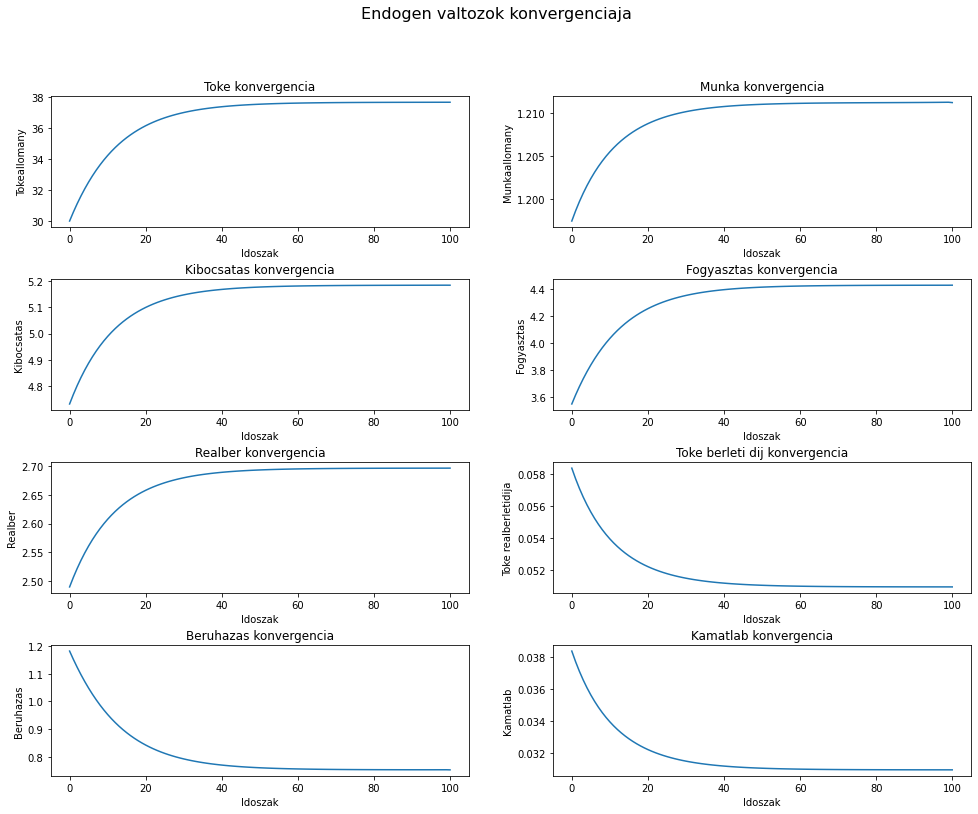

In [5]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(16.5, 12.5)
fig.suptitle('Endogen valtozok konvergenciaja', fontsize=16)
plt.subplots_adjust(hspace = 0.4)
axs[0, 0].plot([x for x in range(101)], K)
axs[0, 0].set_title('Toke konvergencia')
axs[0, 0].set_xlabel('Idoszak')
axs[0, 0].set_ylabel('Tokeallomany')
axs[0, 1].plot([x for x in range(101)], L)
axs[0, 1].set_title('Munka konvergencia')
axs[0, 1].set_xlabel('Idoszak')
axs[0, 1].set_ylabel('Munkaallomany')
axs[1, 0].plot([x for x in range(101)], Y)
axs[1, 0].set_title('Kibocsatas konvergencia')
axs[1, 0].set_xlabel('Idoszak')
axs[1, 0].set_ylabel('Kibocsatas')
axs[1, 1].plot([x for x in range(101)], C)
axs[1, 1].set_title('Fogyasztas konvergencia')
axs[1, 1].set_xlabel('Idoszak')
axs[1, 1].set_ylabel('Fogyasztas')
axs[2, 0].plot([x for x in range(101)], w)
axs[2, 0].set_title('Realber konvergencia')
axs[2, 0].set_xlabel('Idoszak')
axs[2, 0].set_ylabel('Realber')
axs[2, 1].plot([x for x in range(101)], rk)
axs[2, 1].set_title('Toke berleti dij konvergencia')
axs[2, 1].set_xlabel('Idoszak')
axs[2, 1].set_ylabel('Toke realberletidija')
axs[3, 0].plot([x for x in range(101)], I)
axs[3, 0].set_title('Beruhazas konvergencia')
axs[3, 0].set_xlabel('Idoszak')
axs[3, 0].set_ylabel('Beruhazas')
axs[3, 1].plot([x for x in range(101)], r)
axs[3, 1].set_title('Kamatlab konvergencia')
axs[3, 1].set_xlabel('Idoszak')
axs[3, 1].set_ylabel('Kamatlab')